<h4>The main objective of this project is to create a Cross-Language Information Retrieval system (CLIR). The sytem has a basic architecture: first it takes in a query in a source language and translates it into the target language. Then the system retrieves the relevant and appropriate documents in the target language, and finally goes through a second round of translation. The user now has a document translated in their own language. The first part of this project is focused on the second translation phase, but I will expand it and improve on it with time. <br>
The source and target language are Spanish and English, respectively. The main reason being that Spanish is the second most commonly spoken language in the United States and the World. This will make English-only documents more accessible to Spanish speakers. </h4>

In [1]:
#python -m spacy download es_core_news_sm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import string
import re

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout, LSTM
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy

import nltk
from nltk import tokenize
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer

import spacy
!spacy download es_core_news_sm
import es_core_news_sm

nlp = spacy.load("en_core_web_sm")
nltk.download('punkt')

from nltk.corpus import stopwords
nltk.download('stopwords')

     |████████████████████████████████| 16.2MB 6.4MB/s 
  Created wheel for es-core-news-sm: filename=es_core_news_sm-2.2.5-cp37-none-any.whl size=16172936 sha256=05baf8e8ea3ff9de85ecbcc0e5fbb7e55b80cf4027713a907d0ba529ce35a1af
  Stored in directory: /tmp/pip-ephem-wheel-cache-sa7da60g/wheels/05/4f/66/9d0c806f86de08e8645d67996798c49e1512f9c3a250d74242
Successfully built es-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
lang_df = pd.read_csv('sent_translations.csv')
lang_df.drop('Unnamed: 0', 1, inplace=True)

In [4]:
lang_df.head()

,Spanish,English
0,La violencia en sus diversas variantes está pr...,Violence in its several variations is present ...
1,Este fenómeno impacta a un alto por ciento de ...,This phenomenon impacts a high percentage of c...
2,La globalización y la continua búsqueda de las...,Globalization and the continued quest of natio...
3,"Asimismo, son estas nuevas tecnologías las que...",It is also these new technologies that can fos...
4,La educación está en constante transmutación c...,Education is constantly changing because of th...


## Sentence Alignment

In [5]:
# these rows were not correctly aligned
lang_df.drop([5, 96, 98, 100, 103, 106, 109, 112, 259, 260,261,262, 263, 264, 266, 272, 273, 274, 275, 276, 367, 
              375,410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421,422, 434, 435, 436, 281, 282,283, 284, 285, 286,
             287,288, 289, 290, 291, 292,293,294, 295, 296, 297,298,299,300, 301, 302, 397, 398,399,400, 
              401, 402, 403, 404, 405,406,407,408,450,451,452,453,455,456,457, 458, 459, 460, 461, 462, 505, 506,507,508,509], inplace=True)

lang_df.drop_duplicates(inplace=True)
lang_df.reset_index(inplace=True, drop=True)
lang_df.drop([433,434,435,436,437,438,439,440], inplace=True)
lang_df.reset_index(drop=True, inplace=True)

In [6]:
lang_df.drop([241, 242, 243, 244, 245, 246, 247, 248, 406, 759, 760, 954, 955, 956, 957, 958, 959, 960, 1043, 1044, 1045, 1046, 1047, 1048, 149, 1050, 1052, 1053, 1054, 1055, 1056, 1057, 1058], inplace=True)
lang_df.reset_index(inplace=True, drop=True)

In [7]:
len(lang_df)

1168

In [8]:
# Shorten length of sentences, remove outliers
#lang_df['English'] = lang_df['English'].apply(lambda x: x.split(' ')[:25]).apply(lambda x: ' '.join(x))
#lang_df['Spanish'] = lang_df['Spanish'].apply(lambda x: x.split(' ')[:25]).apply(lambda x: ' '.join(x))

#### Example Sentence

In [9]:
lang_df['English'][6]

'They also include and implement effective strategies aimed at prevention and intervention to combat violent acts among the same, creating a safe and peaceful environment in the learning community.'

In [10]:
lang_df['Spanish'][6]

'Asimismo, comprendan e implanten estrategias efectivas dirigidas a la prevención e intervención para combatir los actos violentos entre iguales; creando un ambiente seguro y de paz en la comunidad de aprendizaje.'

## Exploratory Data Analysis

In [11]:
stopword_en = stopwords.words('english')
stopword_sp = stopwords.words('spanish')

In [12]:
def text_stats(doc,stopword):
    """
    Pass in a single document
    as a string
    """
    #sents = sent_tokenize(doc)
    #num_sents = len(sents)
    tokens = word_tokenize(doc)
    num_tokens = len(tokens)
    words = [token.lower() for token in tokens 
             if not token in string.punctuation
             if not token.lower() in stopword]
    num_words = len(words)
    vocab = len(set(words))
    characters = sum([len(word) for word in words])
    spacy_doc = nlp(doc)
    numerics = ['DATE', 'TIME', 'PERCENT', 'MONEY', 'QUANTITY','ORDINAL', 'CARDINAL']
    entities = [entity.text for entity in spacy_doc.ents 
                if not entity.label_ in numerics]
    num_entities = len(set(entities))
    #words_sent = num_words / num_sents
    char_word = characters / num_words
    lex_div = vocab / num_words
    stats = [num_tokens, num_words, vocab, num_entities, char_word, lex_div]
    return stats

In [13]:
def plot_wordcloud(stopword, text, colormap='Reds', mask=None,max_words=500,max_font_size=100,figure_size=(24.0,16.0),title = None, title_size=40, image_color=False):
    stopwords = set(stopword)
    more_stopwords = {'one', 'br', 'pr', 'th', 'sayi', 'fo', 'Unknown', 'las', 'la', 'va', 'ha', 'en', 
                          'un', 'han', 'c', 'estas', 'estos', 'dtype', 'se', 'por', 'para', 'de', 'este', 'está','t', 'y', 'm', 'r', 'v', 'p', 'sb', 'iii', 'i'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    colormap = colormap,
                    stopwords = stopword,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    plt.imshow(wordcloud);
    plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                              'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

In [14]:
docs_stats = []
for doc in lang_df['English']:
    docs_stats.append(text_stats(doc, stopword_en))

#### Descriptive Statistics

In [15]:
textstats_en = pd.DataFrame(docs_stats, columns=['Tokens', 'Words', 'Vocabulary', 'Entities', 'Avg Word Length', 'Lexical Diversity'])
textstats_en.head()

,Tokens,Words,Vocabulary,Entities,Avg Word Length,Lexical Diversity
0,13,6,6,0,7.333333,1.0000
1,30,16,15,0,7.500000,0.9375
2,26,15,15,0,8.666667,1.0000
3,23,11,11,0,7.909091,1.0000
4,21,10,10,0,7.900000,1.0000


In [16]:
textstats_en.describe()

,Tokens,Words,Vocabulary,Entities,Avg Word Length,Lexical Diversity
count,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000
mean,33.213185,17.342466,16.348459,0.756849,7.512762,0.964815
std,20.374765,10.718451,8.824927,1.367685,1.037135,0.065260
min,2.000000,1.000000,1.000000,0.000000,3.583333,0.425532
25%,21.000000,11.000000,11.000000,0.000000,6.878750,0.944444
50%,28.000000,15.000000,15.000000,0.000000,7.550505,1.000000
75%,40.000000,21.000000,20.000000,1.000000,8.160088,1.000000
max,199.000000,114.000000,80.000000,12.000000,13.000000,1.000000


In [17]:
nlp = es_core_news_sm.load()

In [18]:
docs_stats = []
for doc in lang_df['Spanish']:
    docs_stats.append(text_stats(doc, stopword_sp))

In [19]:
textstats_sp = pd.DataFrame(docs_stats, columns=['Tokens', 'Words', 'Vocabulary', 'Entities', 'Avg Word Length', 'Lexical Diversity'])
textstats_sp.head()

,Tokens,Words,Vocabulary,Entities,Avg Word Length,Lexical Diversity
0,16,6,6,0,8.166667,1.0
1,41,16,16,0,7.562500,1.0
2,30,16,16,0,9.437500,1.0
3,28,13,13,0,8.615385,1.0
4,23,11,11,0,9.272727,1.0


In [20]:
textstats_sp.describe()

,Tokens,Words,Vocabulary,Entities,Avg Word Length,Lexical Diversity
count,1168.000000,1168.00000,1168.000000,1168.000000,1168.000000,1168.000000
mean,35.892979,17.92637,17.045377,1.064212,8.038847,0.969434
std,21.621018,10.97179,9.282143,1.752018,1.068013,0.059888
min,3.000000,1.00000,1.000000,0.000000,4.000000,0.500000
25%,23.000000,11.00000,11.000000,0.000000,7.411765,0.952381
50%,31.000000,15.00000,15.000000,0.000000,8.080128,1.000000
75%,42.000000,22.00000,21.000000,1.000000,8.714286,1.000000
max,220.000000,113.00000,88.000000,16.000000,13.000000,1.000000


#### Univariate Analysis (based on descriptive statistics)

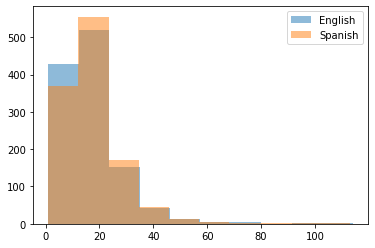

In [21]:
plt.hist(textstats_en['Words'], alpha = .5, label = "English")
plt.hist(textstats_sp['Words'], alpha = .5, label = "Spanish")
plt.legend(loc="upper right")
plt.show()

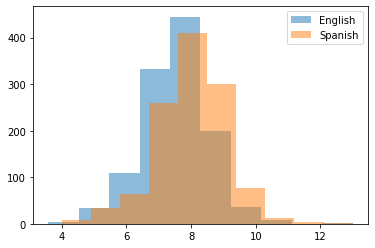

In [22]:
plt.hist(textstats_en['Avg Word Length'], alpha = .5, label = "English")
plt.hist(textstats_sp['Avg Word Length'], alpha = .5, label = "Spanish")
plt.legend(loc="upper right")
plt.show()

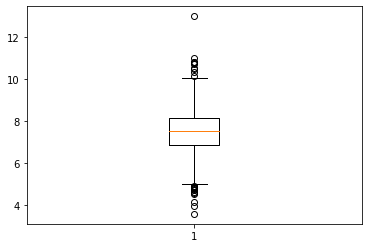

In [23]:
plt.boxplot(textstats_en['Avg Word Length'])
plt.show()

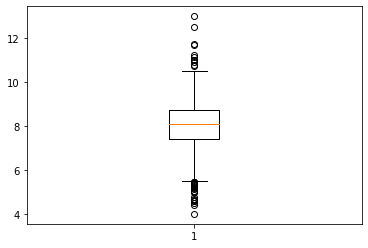

In [24]:
plt.boxplot(textstats_sp['Avg Word Length'])
plt.show()

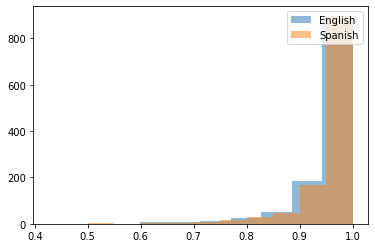

In [25]:
plt.hist(textstats_en['Lexical Diversity'], alpha = .5, label = "English")
plt.hist(textstats_sp['Lexical Diversity'], alpha = .5, label = "Spanish")
plt.legend(loc="upper right")
plt.show()

#### Word Cloud (for word frequency comparison)

In [26]:
# English text
en_doc = nlp(" ".join(lang_df['English']))
en_without_stopwords = [token for token in en_doc if not token.is_stop]
lemmas = [token.lemma_ for token in en_without_stopwords]

# Spanish text
sp_doc = nlp(" ".join(lang_df['Spanish']))
sp_without_stopwords = [token for token in en_doc if not token.is_stop]
lemmas = [token.lemma_ for token in sp_without_stopwords]

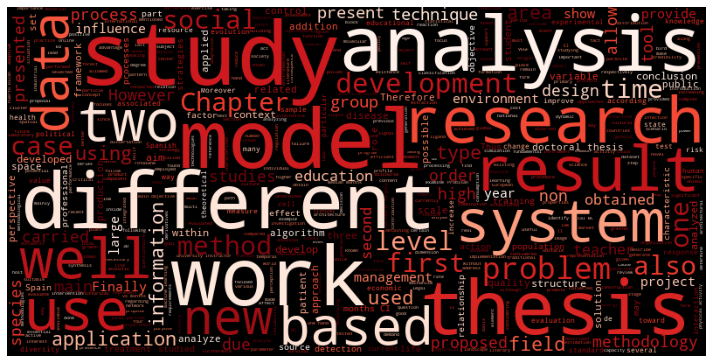

In [27]:
plot_wordcloud(stopword_en, en_doc, figure_size=(10,10))

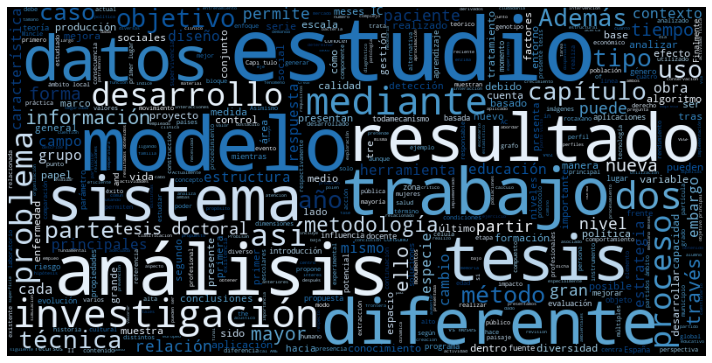

In [28]:
plot_wordcloud(stopword_sp, sp_doc, colormap='Blues', figure_size=(10,10))

We can see the comparison in language in the descriptive summary, histograms and wordclouds. This is important for machine translation and even more so with a small dataset. 

### Preprocessing Text

Then, I did some basic preprocessing such as, punctuation, tokenization, padding, and removing stopwords

In [29]:
def remove_punctuation(text):
    return re.sub(r'[^\w\s]','',text)

In [30]:
def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    # TODO: Implement
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    return tokenizer.texts_to_sequences(x), tokenizer

In [31]:
lang_df['English'] = lang_df['English'].apply(lambda x: word_tokenize(x))
lang_df['Spanish'] = lang_df['Spanish'].apply(lambda x: word_tokenize(x))

lang_df['English_tokenized'] = lang_df['English'].apply(lambda x: [item for item in x if item not in stopword_en])
lang_df['Spanish_tokenized'] = lang_df['Spanish'].apply(lambda x: [item for item in x if item not in stopword_sp])

lang_df['English_tokenized'] = lang_df['English_tokenized'].apply(lambda x: ' '.join(x))
lang_df['Spanish_tokenized'] = lang_df['Spanish_tokenized'].apply(lambda x: ' '.join(x))

In [32]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    # TODO: Implement
    return pad_sequences(x, maxlen=length, padding='post')


def preprocessed(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)
    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)
    

    return preprocess_x, preprocess_y, x_tk, y_tk

In [33]:
lang_df.head()

,Spanish,English,English_tokenized,Spanish_tokenized
0,"[La, violencia, en, sus, diversas, variantes, ...","[Violence, in, its, several, variations, is, p...",Violence several variations present areas soci...,La violencia diversas variantes presente ámbit...
1,"[Este, fenómeno, impacta, a, un, alto, por, ci...","[This, phenomenon, impacts, a, high, percentag...",This phenomenon impacts high percentage childr...,Este fenómeno impacta alto ciento niños mundo ...
2,"[La, globalización, y, la, continua, búsqueda,...","[Globalization, and, the, continued, quest, of...",Globalization continued quest nations develop ...,La globalización continua búsqueda naciones de...
3,"[Asimismo, ,, son, estas, nuevas, tecnologías,...","[It, is, also, these, new, technologies, that,...","It also new technologies foster inequalities ,...","Asimismo , nuevas tecnologías pueden llegar fo..."
4,"[La, educación, está, en, constante, transmuta...","[Education, is, constantly, changing, because,...","Education constantly changing political , soci...",La educación constante transmutación consecuen...


In [34]:


lang_df['English_tokenized'] = lang_df['English_tokenized'].apply(remove_punctuation)
lang_df['Spanish_tokenized'] = lang_df['Spanish_tokenized'].apply(remove_punctuation)

In [35]:
sp_stemmer = SnowballStemmer("spanish")
en_stemmer = SnowballStemmer("english")

lang_df['English_tokenized'] = [en_stemmer.stem(stem) for stem in lang_df['English_tokenized']]
lang_df['Spanish_tokenized'] = [sp_stemmer.stem(stem) for stem in lang_df['Spanish_tokenized']]

In [36]:
# lowercase everything
lang_df['English_tokenized'] = lang_df['English_tokenized'].apply(lambda x: x.lower())
lang_df['Spanish_tokenized'] = lang_df['Spanish_tokenized'].apply(lambda x: x.lower())
#lang_df['Spanish'] = lang_df['Spanish'].apply(lambda x: x.lower())

In [37]:
lang_df.head()

,Spanish,English,English_tokenized,Spanish_tokenized
0,"[La, violencia, en, sus, diversas, variantes, ...","[Violence, in, its, several, variations, is, p...",violence several variations present areas soci...,la violencia diversas variantes presente ambit...
1,"[Este, fenómeno, impacta, a, un, alto, por, ci...","[This, phenomenon, impacts, a, high, percentag...",this phenomenon impacts high percentage childr...,este fenomeno impacta alto ciento niños mundo ...
2,"[La, globalización, y, la, continua, búsqueda,...","[Globalization, and, the, continued, quest, of...",globalization continued quest nations develop ...,la globalizacion continua busqueda naciones de...
3,"[Asimismo, ,, son, estas, nuevas, tecnologías,...","[It, is, also, these, new, technologies, that,...",it also new technologies foster inequalities ...,asimismo nuevas tecnologias pueden llegar fom...
4,"[La, educación, está, en, constante, transmuta...","[Education, is, constantly, changing, because,...",education constantly changing political socia...,la educacion constante transmutacion consecuen...


In [38]:
preproc_english_sentences, preproc_spanish_sentences, english_tokenizer, spanish_tokenizer =\
preprocessed(lang_df['English_tokenized'], lang_df['Spanish_tokenized'])
    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_spanish_sequence_length = preproc_spanish_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index) + 1
spanish_vocab_size = len(spanish_tokenizer.word_index) + 1

print(max_english_sequence_length)
print(max_spanish_sequence_length)
print(english_vocab_size)
print(spanish_vocab_size)

115
115
6283
7295


In [39]:
# preproc_english_sentences (preprocess_x)
# preproc_spanish_sentence (preprocess_y)
# english tokenizer (x_tk)
# spanish_tokenizer (y_tk)

In [40]:
preproc_english_sentences[5]

array([2982, 1422, 1423,  471, 1424,  271, 2983,  564, 1959,   58,  308,
       2984, 1069,  699,   82,  112,  179,  152,  864, 1425,  699,  271,
        565,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

The maximum sentence length, for both languages, is 115. This is why the padding (0's) is so long after the actual texts

## All Models

This function will allow me to convert the encoding to text once I my model can predict

In [41]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.


# Model 1: Simple Encoder-Decoder using GRU

In [42]:
def encdec_model(input_shape, output_sequence_length, english_vocab_size, spanish_vocab_size):
    """
    Build and train an encoder-decoder model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param spanish_vocab_size: Number of unique Spanish words in the dataset
    :return: Keras model built, but not trained
    """
    # OPTIONAL: Implement
    
    # Hyperparameters
    learning_rate = 0.05
    
    # Build the layers    
    model = Sequential()
    # Encoder
    model.add(GRU(256, input_shape=input_shape[1:], go_backwards=True))
    model.add(RepeatVector(output_sequence_length))
    # Decoder
    model.add(GRU(500, return_sequences=True))
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(spanish_vocab_size, activation='softmax')))

    # Compile model
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    
    return model

In [43]:
# Reshape the input
tmp_x = pad(preproc_english_sentences, preproc_spanish_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_spanish_sentences.shape[-2], 1))

# Train and Print prediction(s)
encdec_rnn_model = encdec_model(
    tmp_x.shape,
    preproc_spanish_sentences.shape[1],
    len(english_tokenizer.word_index)+1,
    len(spanish_tokenizer.word_index)+1)

encdec_rnn_model.summary()

encdec_rnn_model.fit(tmp_x, preproc_spanish_sentences, batch_size=30, epochs=40, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 256)               198912    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 115, 256)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 115, 500)          1137000   
_________________________________________________________________
time_distributed (TimeDistri (None, 115, 1024)         513024    
_________________________________________________________________
dropout (Dropout)            (None, 115, 1024)         0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 115, 7295)         7477375   
Total params: 9,326,311
Trainable params: 9,326,311
Non-trainable params: 0
______________________________________________

In [44]:
# Print prediction(s)
print("Prediction:")
print(logits_to_text(encdec_rnn_model.predict(tmp_x[:1])[0], spanish_tokenizer))
print(lang_df['Spanish_tokenized'][:1])

print("\nOriginal text:")
print(lang_df['English_tokenized'][:1])

Prediction:
<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
0    la violencia diversas variantes presente ambit...
Name: Spanish_tokenized, dtype: object

Original text:
0    violence several variations present areas soci...
Name: English_tokenized, dtype: object


The model started with a high loss function and did not go down. This could be because the model is stuck at a local minima. The reason for the high accuracy score is because of the 0 padding matching both translations. Notice that the prediction just consists of PAD values

### Model 2: Embedding using LSTM + Bidirectional layers

In [45]:
 def model_final(input_shape, output_sequence_length, english_vocab_size, spanish_vocab_size):
    """
    Build and train a model that incorporates embedding, encoder-decoder, and bidirectional RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param spanish_vocab_size: Number of unique Spanish words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Implement

    # Hyperparameters
    learning_rate = 0.05
    
    # Build the layers    
    model = Sequential()
    # Embedding
    model.add(Embedding(english_vocab_size+1, 128, input_length=input_shape[1],
                         input_shape=input_shape[1:]))
    # Encoder
    model.add(Bidirectional(GRU(128)))
    model.add(RepeatVector(output_sequence_length))
    # Decoder
    model.add(Bidirectional(GRU(300, return_sequences=True)))
    model.add(TimeDistributed(Dense(512, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(spanish_vocab_size, activation='softmax')))
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model


print('Final Model Loaded')

Final Model Loaded


In [46]:
def final_predictions(x, y, x_tk, y_tk, sent):
    """
    Gets predictions using the final model
    :param x: Preprocessed English data
    :param y: Preprocessed Spanish data
    :param x_tk: English tokenizer
    :param y_tk: Spanish tokenizer
    """
    # TODO: Train neural network using model_final
    model = model_final(x.shape,y.shape[1],
                        len(x_tk.word_index)+1,
                        len(y_tk.word_index)+1)
    model.summary()
    model.fit(x, y, batch_size=30, epochs=40, validation_split=0.2)

In [47]:
final_predictions(preproc_english_sentences, preproc_spanish_sentences, english_tokenizer, spanish_tokenizer)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 115, 128)          804352    
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               198144    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 115, 256)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 115, 600)          1004400   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 115, 512)          307712    
_________________________________________________________________
dropout_1 (Dropout)          (None, 115, 512)          0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 115, 7295)        

KeyError: ignored

The model started off with a high loss function and stayed at this constant number until the last epoch. The reason for the high accuracy score is because the 0 paddings match with each other in both translations. This is not a good model to run or some hyperparameter tunings are necessary. The model cannot predict certain words such as 'globalizacion'.

### Model 3: Embedding (masking zeros) using multiple LSTM layers 

In [56]:
def embed_model(input_shape, output_sequence_length, english_vocab_size, spanish_vocab_size):
    """
    Build and train a RNN model using word embedding on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param spanish_vocab_size: Number of unique Spanish words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Implement

    # Hyperparameters
    learning_rate = 0.005
    
    # TODO: Build the layers
    model = Sequential()
    model.add(Embedding(english_vocab_size+1, 256, input_length=input_shape[1], 
                        input_shape=input_shape[1:], mask_zero=True))
    model.add(LSTM(256, return_sequences=True))  
    model.add(LSTM(256, return_sequences=True)) 
    model.add(LSTM(256, return_sequences=True)) 
    model.add(LSTM(256, return_sequences=True))  
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(spanish_vocab_size, activation='softmax'))) 

    # Compile model
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

# TODO: Reshape the input
tmp_x = pad(preproc_english_sentences, preproc_spanish_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_spanish_sentences.shape[-2]))

# TODO: Train the neural network
embed_rnn_model = embed_model(
    tmp_x.shape,
    preproc_spanish_sentences.shape[1],
    len(english_tokenizer.word_index)+1,
    len(spanish_tokenizer.word_index)+1)

embed_rnn_model.summary()

embed_rnn_model.fit(tmp_x, preproc_spanish_sentences, batch_size=32, epochs=40, validation_split=0.2)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 115, 256)          1608704   
_________________________________________________________________
lstm_10 (LSTM)               (None, 115, 256)          525312    
_________________________________________________________________
lstm_11 (LSTM)               (None, 115, 256)          525312    
_________________________________________________________________
lstm_12 (LSTM)               (None, 115, 256)          525312    
_________________________________________________________________
lstm_13 (LSTM)               (None, 115, 256)          525312    
_________________________________________________________________
time_distributed_10 (TimeDis (None, 115, 1024)         263168    
_________________________________________________________________
dropout_5 (Dropout)          (None, 115, 1024)        

In [57]:
# Print prediction(s)
print("Prediction:")
print(logits_to_text(embed_rnn_model.predict(tmp_x[:1])[0], spanish_tokenizer))
print(lang_df['Spanish_tokenized'][:1])

print("\nOriginal text:")
print(lang_df['English_tokenized'][:1])

Prediction:
el cambio diversas conformaron trabajo ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos ambitos
0    la violencia diversas variantes presente ambit...
Name: Spanish_

Conclusion:<br>
The best model to use for machine translation is the third model (embedding with multiple layers). It produced the lowest loss function the prediction wasn't too far from the original. <br>
The main issue currently is the lack of data and length of some of the sentences. The maximum length of both my English and Spanish translation is 115 words. On average, however, is around 20-25 words. I will need to go back and remove these outliers since it is affecting how well my prediction is doing. As you can see in the example predictions. The translation can't go further than the first few words before repeating the same last word over and over again. 

I can improve my model if I collect more data or do transfer learning with pretrained models (BERT). I could also use text augmentation with Wordnet.

The next step is constructing the second part of CLIR. This is creating the query translation part and typing both aspects together to complete the system.

references: source: https://towardsdatascience.com/language-translation-with-rnns-d84d43b40571

I used this source code for some preprocessing and the models used with a few tweaks for implementation